# load project

This is project for modeling combined depth mask

# Define project root

In [3]:
import sys
import os
from pathlib import Path

try:
    import google.colab
    # Colab, путь к проекту абсолютный
    project_root = Path("/content/Depth_Maker").resolve()
    print("Running in Google Colab environment.")
except ImportError:
    # Локальное окружение
    project_root = Path.cwd().parent  # Путь к корневой директории Depth_Maker
    print("Running locally.")

# Добавляем проект в sys.path
sys.path.append(str(project_root))
print(f"Project root: {project_root}")

Running locally.
Project root: /workspace/Depth_Maker


# Init pipeline
по конструированию итого изображения

**background** - можно картинкой, можно сразу маской глубины какого-то фона.



пути в Colab без r"" и бэкслешей

In [4]:
# идем в в текущую версию проекта, сейчас depth_maker.dm_v1
from depth_maker.dm_v1.constructor_layered_image import LogoOverlayPipeline

#background_filename=r"tests\backgrounds\tree_road_2.webp" # local
background_filename = "tests/backgrounds/tree_road_2.webp"

#combined_image_path=r"results\combined_image.png" # local
combined_image_path = "results/combined_image.png"

pipeline = LogoOverlayPipeline(
    dir_path=project_root,
    background_filename=background_filename,
    background_size=(1024, 864), # лучше кратно 16
    combined_image_path = combined_image_path,
    enable_logging=True
)



# Load images of objects

**objects** - может быть:
- какой-то картинка объекта на белом или черном фоне;
- или например где-то сделанная маска глубины, но обрезанная по краям и помещенная на черный фо;
- или проекция 3D объекта, обрезанная по краям и помещенная на черный фон;

parametrs:
- `filename` - путь к файлу в проекте. Можно сделать папку и подпапки туда грузить фоны и объекты с белым фоном.

- `sizes` - замер объекта при расположении на фоне

- `point` - (X, Y) координата правой нижней точки

- `alpha` - прозрачность alpha канала





также пути в Colab  без r"" и бэкслешей

INFO:LogoOverlayPipeline:Combined image saved to /workspace/Depth_Maker/results/combined_image.png.


Layered image object saved to /workspace/Depth_Maker/results/layered_image_object.pkl


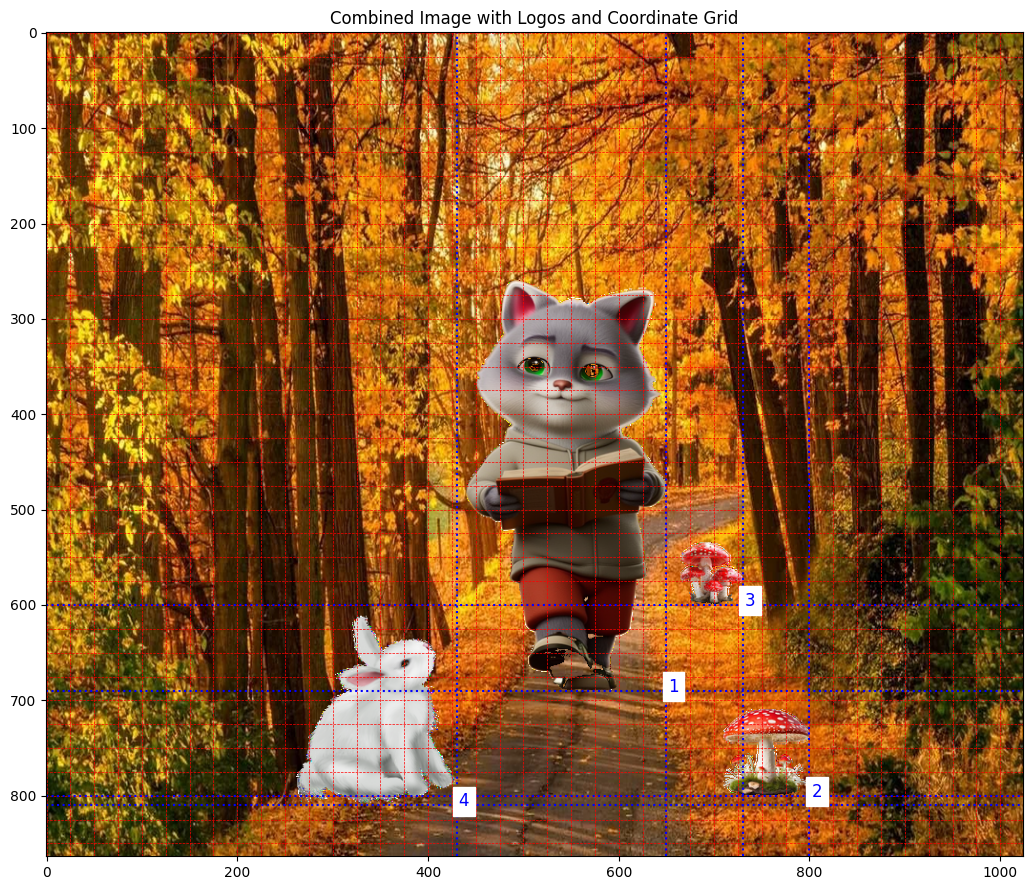

In [5]:
# Create a test logo and add it to the logos_info list
# pipeline.create_test_logo() #constarct test simple image

#
pipeline.logos_info = [
    {
        #'filename': r"tests\objects\sbercat_book.png", # local
        'filename': "tests/objects/sbercat_book.png",
        'sizes': (210, 430),
        'point': (650, 690),
        'alpha': 1
    },

    {
        #'filename': r"tests\objects\pngtree_red_1.png", # local
        'filename': "tests/objects/pngtree_red_1.png",
        'sizes': (90, 90),
        'point': (800, 800),
        'alpha': 1
    },

    {
        #'filename': r"tests\objects\pngtree_red_2.png", # local
        'filename': "tests/objects/pngtree_red_2.png",
        'sizes': (65, 65),
        'point': (730, 600),
        'alpha': 1
    },

    {
        #'filename': r"tests\objects\papik_1.png", # local
        'filename': "tests/objects/papik_1.png",
        'sizes': (170, 200),
        'point': (430, 810),
        'alpha': 1
    }

    ]

# Create a layered image object
layered_image = pipeline.overlay_multiple_logos()

# Save the combined image to a file
pipeline.save_combined_image(layered_image)

# Save if need to get caption with help converter later
#file_name = r'results\layered_image_object.pkl' # local
file_name = 'results/layered_image_object.pkl'
save_path = project_root / Path(file_name)


# Save the combined image to a file
layered_image.save(save_path)


# Visualize the combined image with a grid
combined_image = layered_image.render()
pipeline.visualize_with_grid(combined_image)



# Download_model depth model

Сейчас используем только Depth_Anything_V2 модель, как лучшую и она во Flux_tools используется, но можно интегрровать новые и старые, например MiDas

In [6]:
from depth_maker.dm_v1.utils import download_model
# URL модели на Hugging Face
type_encoder = 'vitl'
model_url = f"https://huggingface.co/depth-anything/Depth-Anything-V2-Large/resolve/main/depth_anything_v2_{type_encoder}.pth?download=true"
# Локальный путь для сохранения модели
checkpoint_path = project_root / "checkpoints" / "Depth_Anything_V2" / "depth_anything_v2_vitl.pth"
# Загрузка модели
download_model(model_url, str(checkpoint_path))


/workspace/Depth_Maker/checkpoints/Depth_Anything_V2/depth_anything_v2_vitl.pth:   0%|          | 0.00/1.25G […

# Load saved layered_image_object

In [7]:
from depth_maker.dm_v1.constructor_layered_image import LayeredImageObject
from depth_maker.dm_v1.stylized_layered_masks import StylizedLayeredImageObject

file_name = r'layered_image_object.pkl'
file_path = project_root / 'results' / file_name
# Load the LayeredImageObject
loaded_layered_image = LayeredImageObject.load(str(file_path))


# Get stylized_layered_image_object

- Создаем из loaded_layered_image stylized_layered_image_object применяя выбранные вариант извлечения масок слоев, например `depth_anth`.
- Можно выбирать не `depth_anth`, а например:
 - `lineart` и его параметр:
   - `gaussian_sigma`: `1.0`,
   - `intensity_threshold`: `30`,
 - `canny` и его параметр:
   - `low_threshold`: `50`,
   - `intensity_threshold`: `150`,
- Можно повращать  объект  в плоскости и/или отразить по оси.
  - `rotation_angle`: `10`
  - `reflection`:`horizontal` #`vertical`,`both`,`none`

- Методы `rotation_angle` и  `reflection` планирую или перенести, или скорее просто дополнить в первой шаг по созданию послойного изоббражения из фона и объектов.

*Этот шаг выделен как опция, чтобы можно было далее поиграться контрастность и интенсивностью взаимной слоев и сделать разныей варианта. Так как извлечение маски работает дольше.*

In [8]:
# Локальный путь для сохранения модели
checkpoint_path = project_root / "checkpoints" / "Depth_Anything_V2" / "depth_anything_v2_vitl.pth"

# Background processing parameters
background_params = {
    'method': 'depth_anth',
    # Add more parameters if needed
}

# Logos processing parameters with rotation and canny/lineart
logos_params = [
    {
        'method': 'depth_anth',
        #'rotation_angle': 0,  # No rotation
        'reflection': 'horizontal',  # Явно указываем
        # Add more parameters if needed
    },

    {
        'method': 'lineart',
        'gaussian_sigma': 8.0,
        'intensity_threshold': 30,
        'rotation_angle': 0,  # rotation
        # Add more parameters if needed
    },

    {
        'method': 'canny',
        'low_threshold': 50,
        'high_threshold': 1750,
        #'rotation_angle': 25,  # No rotation
        'reflection': 'horizontal',  # Явно указываем
        # Add more parameters if needed
    },


    {
        'method': 'depth_anth',
        #'rotation_angle': 30 , # No rotation
        #'reflection': 'horizontal',  # Явно указываем
        # Add more parameters if needed
    }
]


# Initialize StylizedLayeredImageObject with depth model
stylized_layered_image = StylizedLayeredImageObject(
    loaded_layered_image,
    background_params=background_params,
    logos_params=logos_params,
    depth_model_checkpoint=checkpoint_path,  # Path to your depth model checkpoint
    depth_encoder='vitl'  # Specify the encoder type used in your model
)

# Сохранение объекта после его создания
#file_name = r'results\stylized_layered_image.pkl' # local
file_name = 'results/stylized_layered_image.pkl'
save_path = project_root / Path(file_name)
stylized_layered_image.save_stylized_layered_image_object(save_path)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Layered image object saved to /workspace/Depth_Maker/results/stylized_layered_image.pkl


## Show in magma view

In [ ]:
stylized_layered_image.visualize_with_grid()

## Show in BW view

- LinArt and Canny have a simple view

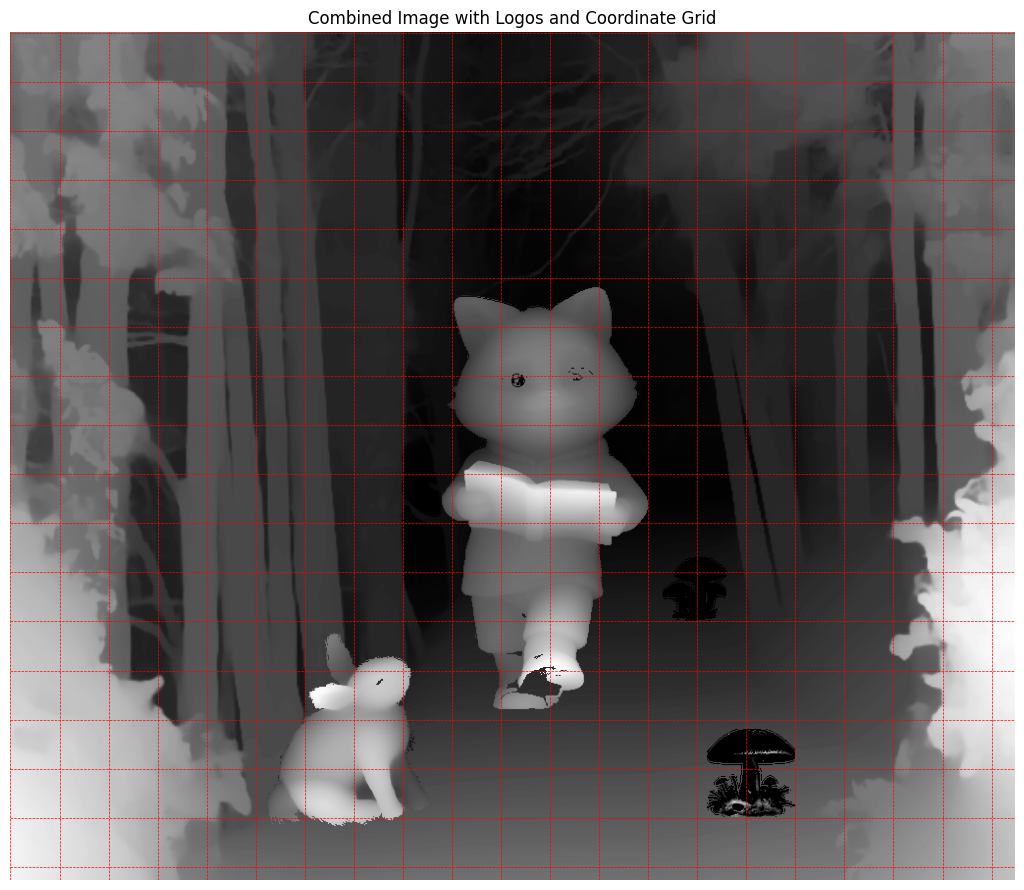

In [5]:
stylized_layered_image.visualize_with_grid(mode = "gray")

## Apply contrast and bridhthess after

it is making quiqly and possibly make different variants for testing in generation.

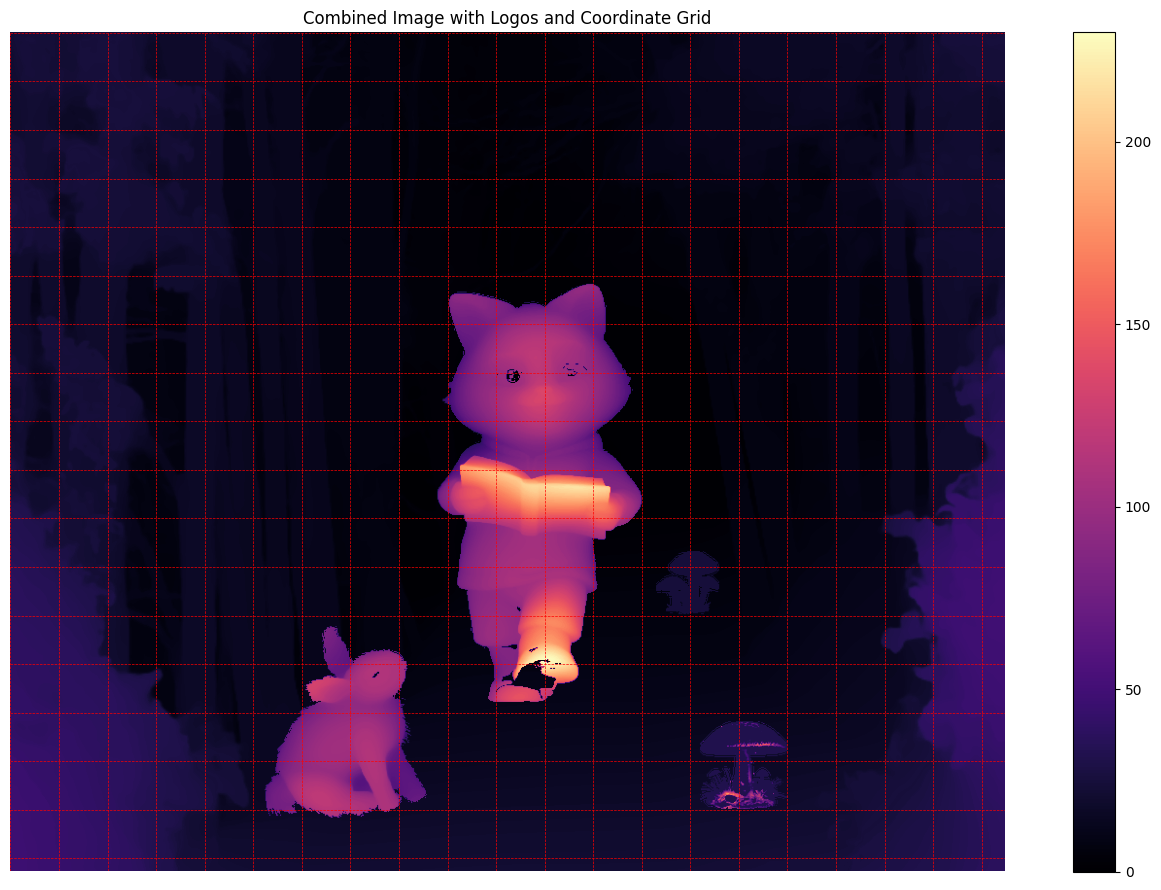

In [9]:
from depth_maker.dm_v1.constructor_layered_image import LayeredImageObject
from depth_maker.dm_v1.stylized_layered_masks import StylizedLayeredImageObject

file_name = r'stylized_layered_image.pkl'
file_path = project_root / 'results' / file_name
# Load the LayeredImageObject
loaded_stylized_layered_image = LayeredImageObject.load(str(file_path))

# Background processing parameters
background_params = {
    'method': 'none',
    'brightness': 0.9,
    'contrast': 0.2,
    # Add more parameters if needed
}

# Logos processing parameters with rotation and canny/lineart
logos_params = [
    {
        'method': 'none',
        'brightness': 10,
        'contrast': 0.9,
    },
    {
        'method': 'none',
        'brightness': 32,
        'contrast': 0.7,
    },

    {
        'method': 'none',
        'brightness': 25,
        'contrast': 0.5,
    },

    {
        'method': 'none',
        'brightness': 35,
        'contrast': 0.4,
    }
]

# Final processing parameters (optional)
final_processing_params = {
    'method': 'threshold',
    'threshold_value': 128
}

# Initialize StylizedLayeredImageObject with depth model
stylized_layered_image = StylizedLayeredImageObject(
    loaded_stylized_layered_image,
    background_params=background_params,
    logos_params=logos_params,
    #final_processing_params=final_processing_params,  # Uncomment if needed
)

stylized_layered_image.visualize_with_grid()

# Make all - masks, roating, reflect, brightness, reflect intime

In [10]:
from depth_maker.dm_v1.constructor_layered_image import LayeredImageObject


file_name = r'layered_image_object.pkl'
file_path = project_root / 'results' / file_name
# Load the LayeredImageObject
loaded_layered_image = LayeredImageObject.load(str(file_path))

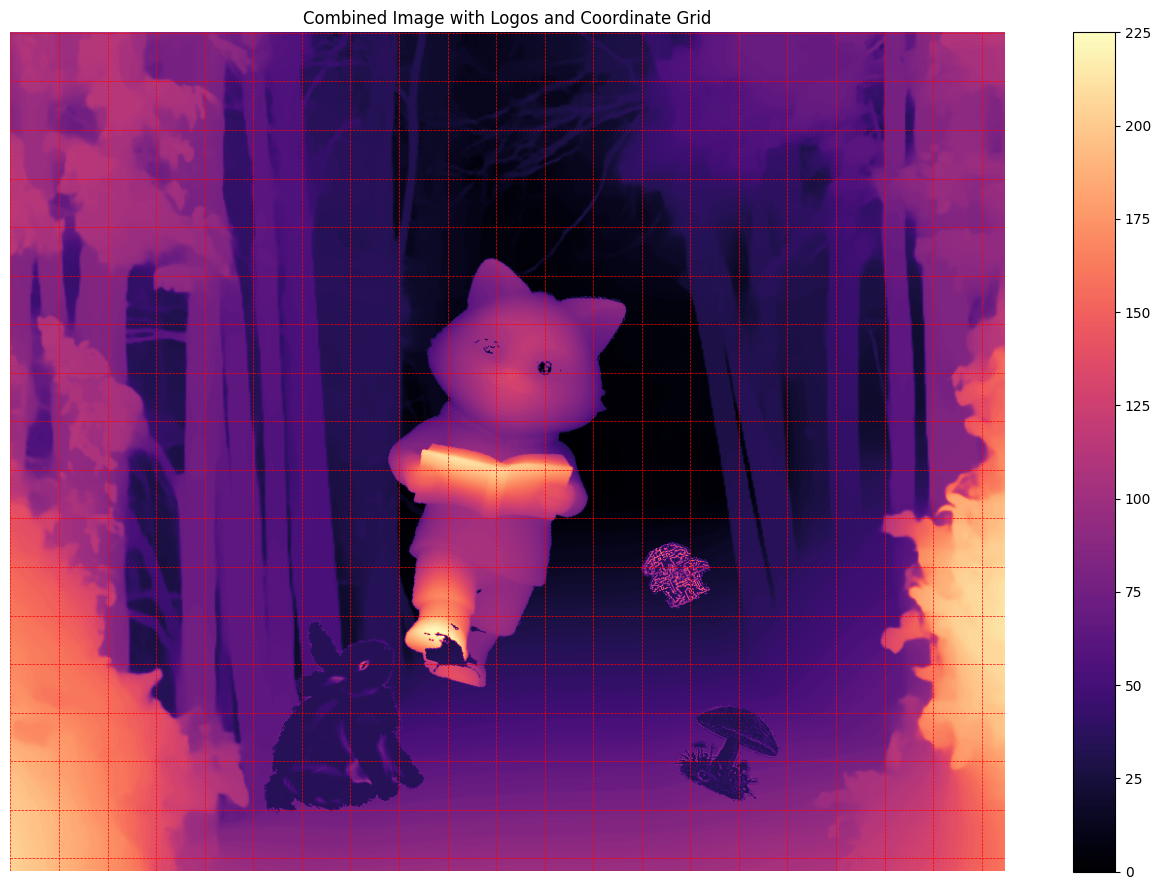

In [11]:
from depth_maker.dm_v1.stylized_layered_masks import StylizedLayeredImageObject
# Локальный путь для сохранения модели
checkpoint_path = project_root / "checkpoints" / "Depth_Anything_V2" / "depth_anything_v2_vitl.pth"

file_name = r'layered_image_object.pkl'
file_path = project_root / 'results' / file_name
# Load the LayeredImageObject
loaded_layered_image = LayeredImageObject.load(str(file_path))

# Background processing parameters
background_params = {
    'method': 'depth_anth',
    'brightness': 0.9,
    'contrast': 0.9,
    # Add more parameters if needed
}

# Logos processing parameters with rotation and canny/lineart
logos_params = [
    {
        'method': 'depth_anth',
        'brightness': 10,
        'contrast': 0.9,
        'reflection`':'horizontal',
         'rotation_angle': -15,  # No rotation
    },
    {
        'method': 'lineart',
        'gaussian_sigma': 1.0,
        'intensity_threshold': 30,
        'brightness': 32,
        'contrast': 0.7,
        'rotation_angle': -25,  # No rotation
        'reflection`':'horizontal',
    },

    {
        'method': 'canny',
        'low_threshold': 50,
        'high_threshold': 150,
        'brightness': 35,
        'contrast': 0.5,
        'rotation_angle': 25,  # No rotation
        'reflection`':'both',
    },

    {
        'method': 'lineart',
        'gaussian_sigma': 8.0,
        'intensity_threshold': 30,
        'brightness': 35,
        'contrast': 0.4,
        'rotation_angle': 5,  # No rotation
        'reflection`':'vertical',
    }
]

# Final processing parameters (optional)
final_processing_params = {
    'method': 'threshold',
    'threshold_value': 128
}

# Initialize StylizedLayeredImageObject with depth model
stylized_layered_image = StylizedLayeredImageObject(
    loaded_layered_image,
    background_params=background_params,
    logos_params=logos_params,
    #final_processing_params=final_processing_params,  # Uncomment if needed
    depth_model_checkpoint=checkpoint_path,  # Path to your depth model checkpoint
    depth_encoder='vitl'  # Specify the encoder type used in your model
    )

stylized_layered_image.visualize_with_grid()

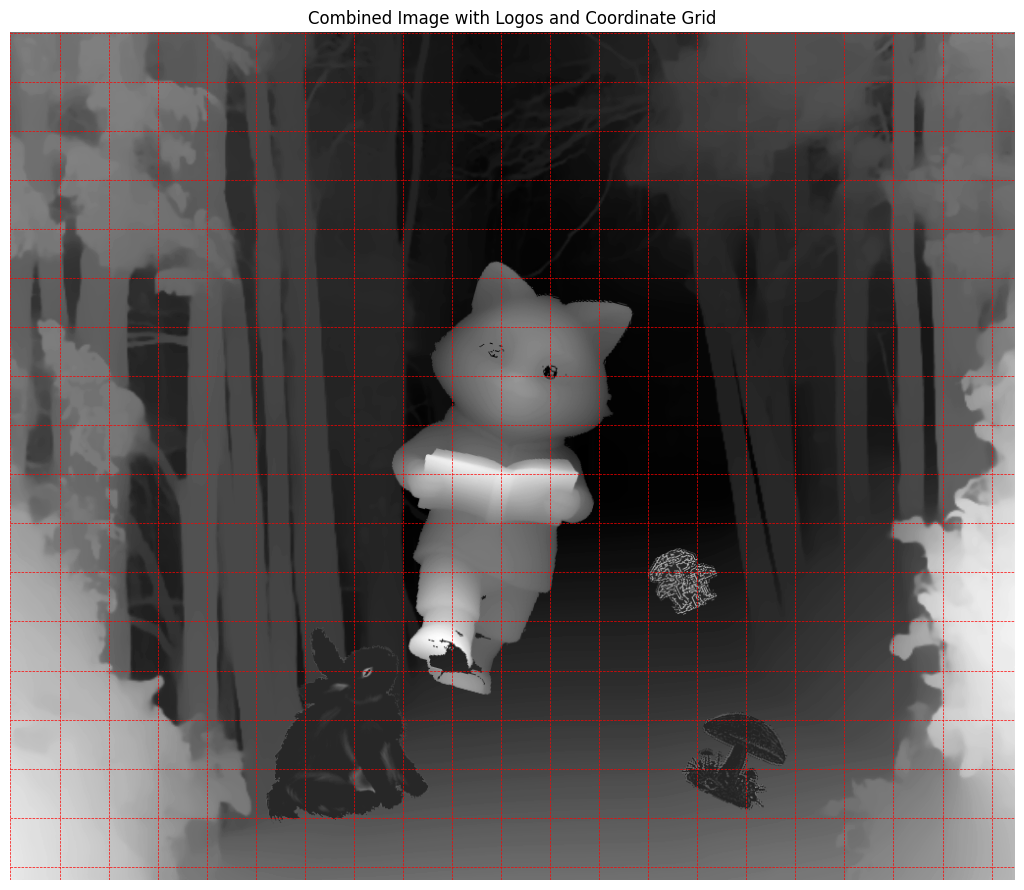

In [12]:
stylized_layered_image.visualize_with_grid(mode = "gray")